The code originally from [here](https://github.com/allanzelener/YAD2K).

To prepare the model:

In [1]:
!wget http://pjreddie.com/media/files/yolo.weights

URL transformed to HTTPS due to an HSTS policy
--2019-04-13 10:55:17--  https://pjreddie.com/media/files/yolo.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolo.weights’

yolo.weights        100%[===================>] 194,49M  1,37MB/s    in 6m 45s  

2019-04-13 11:02:02 (492 KB/s) - ‘yolo.weights’ saved [203934260/203934260]



In [4]:
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov2.cfg

--2019-04-13 11:16:00--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov2.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.84.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.84.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2726 (2,7K) [text/plain]
Saving to: ‘yolov2.cfg’

yolov2.cfg          100%[===================>]   2,66K  --.-KB/s    in 0s      

2019-04-13 11:16:00 (22,2 MB/s) - ‘yolov2.cfg’ saved [2726/2726]



In [5]:
!python yad2k.py yolov2.cfg yolo.weights model_data/yolo.h5

Using TensorFlow backend.
Loading weights.
Weights Header:  [       0        1        0 32013312]
Parsing Darknet config.
Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
Instructions for updating:
Colocations handled automatically by placer.
2019-04-13 11:16:16.554354: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-04-13 11:16:16.578238: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2808000000 Hz
2019-04-13 11:16:16.578940: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55c7c2a85130 executing computations on platform Host. Devices:
2019-04-13 11:16:16.578972: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-04-13 11:16:16.586069: E tensorflow/stream_executor/cuda/cuda_driver.cc:300] failed call to cuInit: C

Saved Keras model to model_data/yolo.h5
Read 50983561 of 50983561.0 from Darknet weights.


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from keras import backend as K
from keras.models import load_model
from yad2k.models.keras_yolo import yolo_eval, yolo_head
from yad2k.utils.draw_boxes import draw_boxes

Using TensorFlow backend.


In [9]:
model_path = 'model_data/yolo.h5'
anchors_path = 'model_data/yolo_anchors.txt'
classes_path = 'model_data/coco_classes.txt'
test_path = 'images'
font_path = 'font/FiraMono-Medium.otf'

score_threshold = .3
iou_threshold = .5

In [10]:
# Load class names
with open(classes_path) as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]
class_names[:10]

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light']

In [11]:
# Load anchors
with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)
anchors

array([[0.57273 , 0.677385],
       [1.87446 , 2.06253 ],
       [3.33843 , 5.47434 ],
       [7.88282 , 3.52778 ],
       [9.77052 , 9.16828 ]])

In [12]:
# Load model
yolo_model = load_model(model_path)
yolo_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
_____________________________________

/home/tambet/miniconda3/envs/nn/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [13]:
# Generate output tensor targets for filtered bounding boxes.
# TODO: Wrap these backend operations with Keras layers.
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(
    yolo_outputs,
    input_image_shape,
    score_threshold=score_threshold,
    iou_threshold=iou_threshold)
print("boxes:", boxes)
print("scores:", scores)
print("classes:", classes)

boxes: Tensor("embedding_lookup/Identity:0", shape=(?, 4), dtype=float32)
scores: Tensor("embedding_lookup_1/Identity:0", shape=(?,), dtype=float32)
classes: Tensor("embedding_lookup_2/Identity:0", shape=(?,), dtype=int64)


/home/tambet/miniconda3/envs/nn/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/tambet/miniconda3/envs/nn/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Found 3 boxes for person.jpg
horse 0.89 (398, 128) (605, 352)
person 0.82 (190, 97) (272, 380)
dog 0.79 (69, 258) (210, 355)
Found 3 boxes for dog.jpg
bicycle 0.84 (81, 115) (554, 466)
truck 0.80 (462, 82) (694, 167)
dog 0.77 (137, 214) (323, 539)
Found 1 boxes for eagle.jpg
bird 0.95 (131, 50) (642, 466)
Found 0 boxes for scream.jpg
Found 10 boxes for kite.jpg
kite 0.82 (597, 78) (673, 151)
person 0.73 (221, 686) (274, 853)
kite 0.63 (279, 236) (303, 278)
person 0.60 (110, 605) (162, 759)
kite 0.55 (571, 346) (598, 366)
kite 0.51 (305, 372) (333, 396)
kite 0.49 (1085, 398) (1108, 420)
person 0.45 (179, 541) (200, 569)
kite 0.45 (474, 340) (490, 357)
person 0.38 (77, 515) (103, 556)
Found 2 boxes for giraffe.jpg
giraffe 0.90 (165, 0) (438, 450)
zebra 0.81 (241, 208) (422, 442)
Found 4 boxes for horses.jpg
horse 0.89 (7, 194) (305, 411)
horse 0.89 (435, 210) (603, 350)
horse 0.75 (252, 197) (435, 371)
horse 0.65 (0, 188) (169, 378)


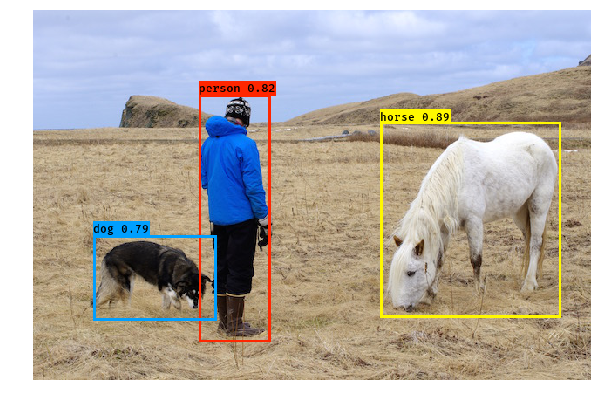

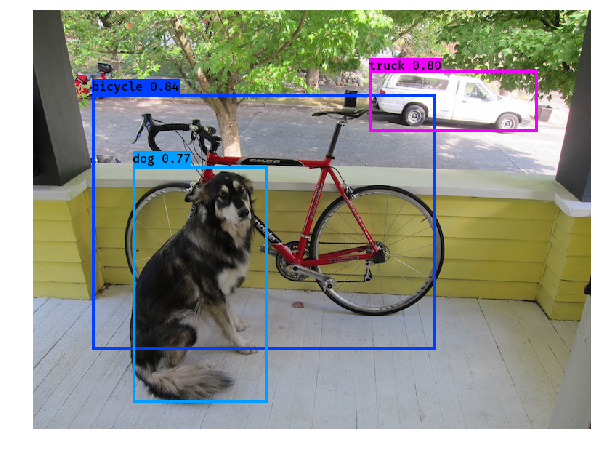

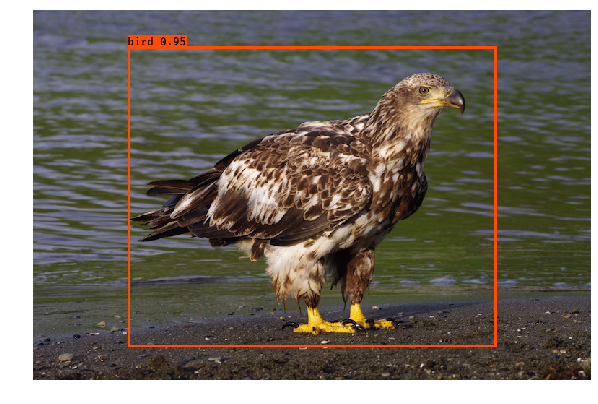

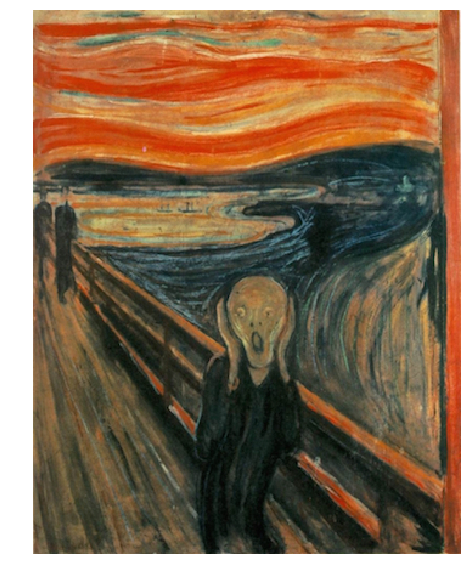

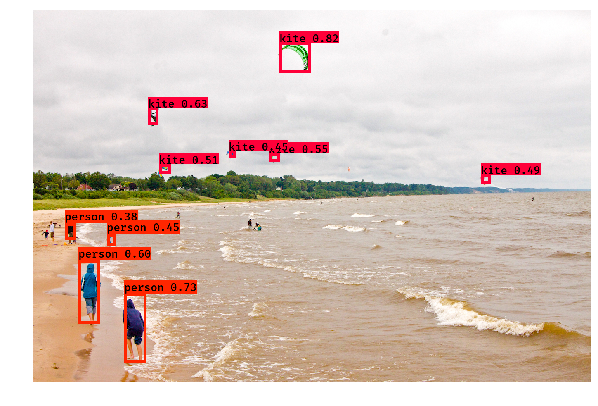

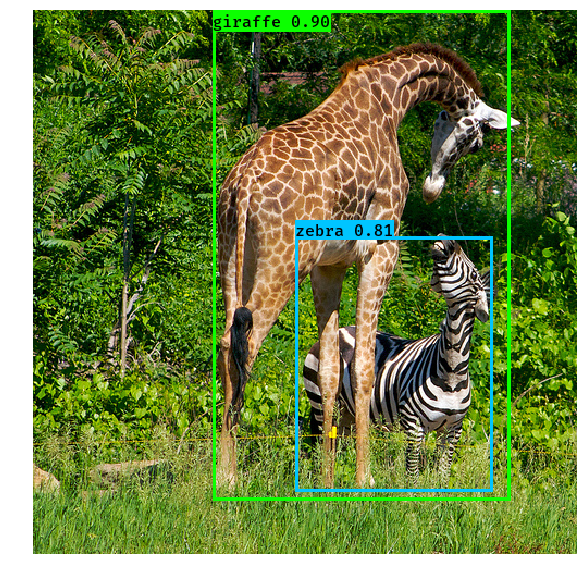

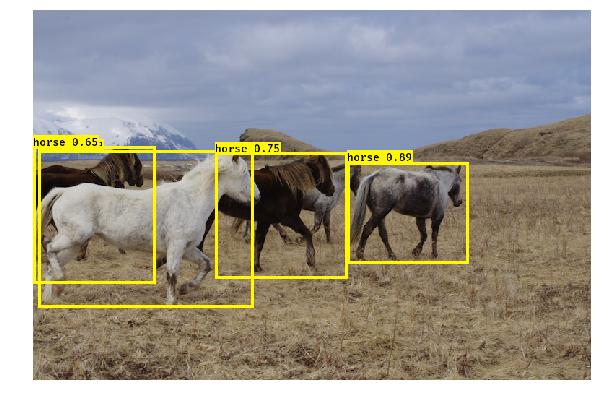

In [15]:
sess = K.get_session()  # TODO: Remove dependence on Tensorflow session.
model_image_size = yolo_model.layers[0].input_shape[1:3]
for image_file in os.listdir(test_path):
    # Load and resize image
    image = imread(os.path.join(test_path, image_file))
    resized_image = resize(image, tuple(reversed(model_image_size)))

    # Perform detection
    out_boxes, out_scores, out_classes = sess.run(
        [boxes, scores, classes],
        feed_dict={
            yolo_model.input: resized_image[np.newaxis],
            input_image_shape: image.shape[:2],
            K.learning_phase(): 0
        })
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    
    image_boxes = draw_boxes(image / 255., out_boxes, out_classes, class_names, out_scores)
    plt.figure(figsize=(10,10))
    plt.imshow(image_boxes)
    plt.axis('off')
plt.show()